In [318]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from urllib.request import urlopen
import requests
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO

from scipy import stats
from sklearn.ensemble import RandomForestClassifier 

### Get data

In [319]:
link = "https://raw.githubusercontent.com/shuailab/ind_498/master/resource/data/AD.csv"
r = requests.get(link)
data = pd.read_csv(StringIO(r.text))
data.head(2)

,DX_bl,AGE,PTGENDER,PTEDUCAT,FDG,AV45,HippoNV,e2_1,e4_1,rs3818361,rs744373,rs11136000,rs610932,rs3851179,rs3764650,rs3865444,MMSCORE,TOTAL13,ID
0,0,71.7,2,14,6.82111,1.105695,0.529299,1,0,1,1,1,1,1,0,0,26,8.00,1
1,0,77.7,1,18,6.36744,1.105695,0.537761,0,0,1,0,1,1,0,0,1,30,1.67,2


### Evaluate models

In [320]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score
X = data.iloc[:, :16]
Y = data['MMSCORE']
lm = linear_model.LinearRegression()

ncv = 10

# test differentmodels
scores = cross_val_score(lm, X, Y, cv=ncv, scoring='neg_mean_squared_error')
print(np.mean(-scores))

scores = cross_val_score(lm, X[["AGE","PTEDUCAT","FDG","AV45","HippoNV","rs3865444"]], Y, cv=ncv, scoring='neg_mean_squared_error')
print(np.mean(-scores))

scores = cross_val_score(lm, X[["AGE","PTEDUCAT"]], Y, cv=ncv, scoring='neg_mean_squared_error')
print(np.mean(-scores))

scores = cross_val_score(lm, X[["AGE","AV45","HippoNV"]], Y, cv=ncv, scoring='neg_mean_squared_error')
print(np.mean(-scores))

3.0235743403043727
3.198992017729683
4.344302171040012
3.7110630650614764


#### Model complexity

In [321]:
from patsy import dmatrix

In [322]:
npoints = 100
x = np.sort(np.random.uniform(0, 100, size=npoints))
xdf = pd.DataFrame(x)
dmat = dmatrix("cr(x, df=3) - 1", {"x": x})

In [323]:
x = np.sort(np.random.uniform(0, 100, size=npoints))
print(np.quantile(x, 0.1))
print(np.quantile(x, 0.33))
print(np.quantile(x, 0.66))

12.10553712641962
34.80641637537578
75.69756891734056


(100, 4)


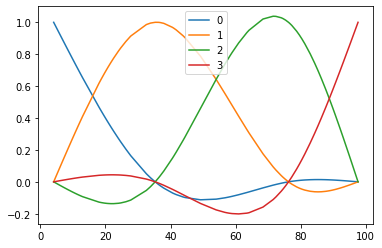

In [324]:
npoints = 100
xdf = pd.DataFrame(x)
dmat = dmatrix("cr(x, df=4) - 1", {"x": x})
# dmat = dmatrix("bs(x, df=4,include_intercept=False) - 1", {"x": x})
ddf = pd.DataFrame(dmat)
print(ddf.shape)
plt.plot(x, ddf[0]);
plt.plot(x, ddf[1]);
plt.plot(x, ddf[2]);
plt.plot(x, ddf[3]);
plt.legend(["0", "1","2","3"])

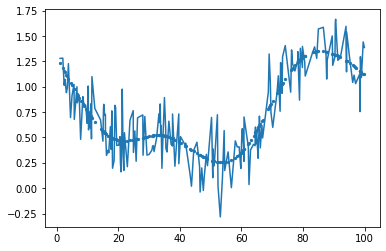

In [325]:
npoints = 200
x = np.sort(np.random.uniform(0, 100, size=npoints))
xdf = pd.DataFrame(x)
dmat = dmatrix("cr(x, df=6) ", {"x": x})
# dmat = dmatrix("bs(x, df=6,include_intercept=False) - 1", {"x": x})
# dmat = dmatrix("bs(x, df=4, degree=3, include_intercept=False) - 1", {"x": x})
ddf = pd.DataFrame(dmat)
ddf.columns = ['X1','X2','X3','X4','X5','X6','X7']
# ddf['X0'] = 1
ddf = ddf[['X1','X2','X3','X4','X5','X6','X7']]
b = np.array([0.82,0.417,-0.32,-0.3,-0.5,0.4,0.3])
y = np.dot(ddf, b) + np.random.normal(0, 0.2, npoints)
y_no_noise = np.dot(ddf, b)

plt.scatter(x, y_no_noise, s=5, marker='o')
plt.plot(x, y);


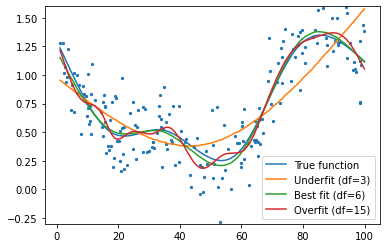

In [326]:
# Fitting Polynomial Regression to the dataset
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

def spline_predict(xdf,df):
    # poly_reg = PolynomialFeatures(degree=df)
    xmatrix = dmatrix("cr(x, df={df})".format(df=df), {"x": xdf})
    xmatrix = pd.DataFrame(xmatrix)
    
    pol_reg = linear_model.LinearRegression()
    pol_reg.fit(xmatrix, y)
    ypred = pol_reg.predict(xmatrix)
    return ypred

plt.scatter(x, y, s=5, marker='o')
plt.plot(x, y_no_noise);

ypred = spline_predict(xdf,3)
plt.plot(x, ypred);
ypred = spline_predict(xdf,6)
plt.plot(x, ypred);
ypred = spline_predict(xdf,15)
plt.plot(x, ypred);
plt.ylim([-0.3, 1.6])
plt.legend(["True function","Underfit (df=3)", 
           "Best fit (df=6)", "Overfit (df=15)"])

In [327]:
def spline_transform(X,df):
    xmatrix = dmatrix("cr(x, df={df})".format(df=df), {"x": X})
    xmatrix = pd.DataFrame(xmatrix)
    return xmatrix

In [328]:
# split training and testing sets
from sklearn.metrics import mean_squared_error
error_df = pd.DataFrame()
for i in range(100):
    for this_degree in range(3,11):
        x_train, x_test, y_train, y_test = train_test_split(xdf, y, test_size=0.33)
        x_train = spline_transform(X=x_train, df=this_degree)
        x_test = spline_transform(X=x_test, df=this_degree)
        lm = linear_model.LinearRegression()
        lm.fit(x_train, y_train)
        ytest_pred = lm.predict(x_test)
        ytrain_pred = lm.predict(x_train)
        train_err = mean_squared_error(ytrain_pred, y_train)
        test_err = mean_squared_error(ytest_pred, y_test)
        

        this_err = pd.DataFrame({'df':[this_degree],
                                 'train_error':[train_err],
                                 'test_error':[test_err]
                                    })
        error_df = error_df.append(this_err)


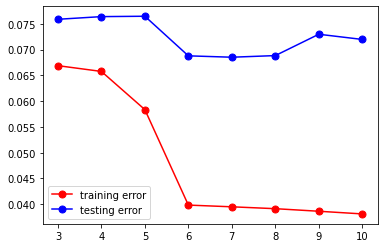

In [330]:
err_agg = error_df.groupby(['df']).agg(
                                training_error = ('train_error','mean'),
                                test_error = ('test_error','mean')
                                      ).reset_index()
err_agg

plt.plot(err_agg.df, err_agg.training_error,  color='red',marker='o',markersize=7)
plt.plot(err_agg.df, err_agg.test_error, color='blue',marker='o',markersize=7);
# plt.ylim(0.03, 0.09)   #
plt.legend(['training error', 'testing error'])


In [340]:
# cross validation
lm = linear_model.LinearRegression()
df_v = range(3,15)
error_df = pd.DataFrame()
for idf in df_v:
    xmatrix = spline_transform(xdf,idf)
    cv_error = - cross_val_score(lm, xmatrix, y, cv=20, scoring='neg_mean_squared_error')
    
    this_err = pd.DataFrame({'df':[idf],
                             'cv_error':[np.mean(cv_error)],
                             'cv_std':[np.std(cv_error)/np.sqrt(20)]
                                    })
    error_df = error_df.append(this_err)
    

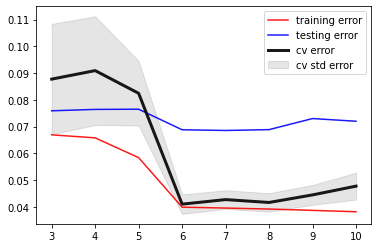

In [341]:
err_agg_cv = pd.merge(err_agg,error_df,left_on='df', right_on="df",how="inner")
err_agg_cv['cv_upper'] = err_agg_cv.cv_error + err_agg_cv.cv_std
err_agg_cv['cv_lower'] = err_agg_cv.cv_error - err_agg_cv.cv_std

fig, ax = plt.subplots()
ax.plot(err_agg_cv['df'], err_agg_cv['training_error'], '-', color='red',alpha=0.9,markersize=3, label='training error')
ax.plot(err_agg_cv['df'], err_agg_cv['test_error'], '-', color='blue',alpha=0.9,markersize=3, label='testing error')
ax.plot(err_agg_cv['df'], err_agg_cv['cv_error'], '-', color='black',linewidth=3,alpha=0.9,markersize=3, label='cv error')
ax.fill_between(err_agg_cv['df'],err_agg_cv['cv_lower'], 
                err_agg_cv['cv_upper'], 
                color='black', alpha=.1, label='cv std error')
ax.legend()

### OOB Error

In [351]:
link = "https://raw.githubusercontent.com/shuailab/ind_498/master/resource/data/AD.csv"
r = requests.get(link)
data = pd.read_csv(StringIO(r.text))
X = data.iloc[:, 1:16]
Y = data['DX_bl']

node_num_v = [2,3,4,5,10,30,50,100]
error_df = pd.DataFrame()
for inode in node_num_v:
    for irep in range(50):
        x_train, x_test, y_train, y_test = train_test_split(
            X, Y, test_size=0.5)
        forest = RandomForestClassifier(max_leaf_nodes=inode,oob_score=True)
        forest.fit(x_train, y_train)
        
        oob_error = 1 - forest.oob_score_
        this_err = pd.DataFrame({'num_nodes':[inode],
                                 'type':['oob_error'],
                                 'error':[oob_error]
                                })
        error_df = error_df.append(this_err)
        
        pred_rf = forest.predict(x_train)
        this_error = sum(pred_rf != y_train)/len(pred_rf)
        this_err = pd.DataFrame({'num_nodes':[inode],
                                 'type':['training_error'],
                                 'error':[this_error]
                                })
        error_df = error_df.append(this_err)
        
        pred_rf = forest.predict(x_test)
        this_error = sum(pred_rf != y_test)/len(pred_rf)
        this_err = pd.DataFrame({'num_nodes':[inode],
                                 'type':['validation_error'],
                                 'error':[this_error]
                                })
        error_df = error_df.append(this_err)


Text(0.5, 1.0, 'Error vs. number of nodes')

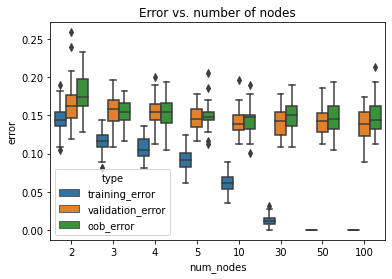

In [352]:
import seaborn as sns
ax = sns.boxplot(x="num_nodes", y="error", hue='type', data=error_df)
ax.set_title("Error vs. number of nodes")

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


Text(0.5, 1.0, 'Error vs. number of trees')

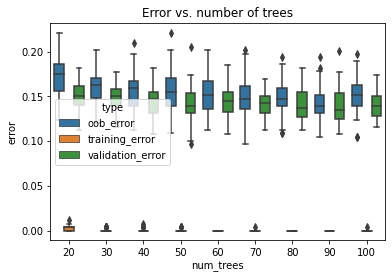

In [358]:
tree_num_v = [20, 30, 40, 50, 60, 70, 80, 90, 100]
error_df = pd.DataFrame()
for itree in tree_num_v:
    for irep in range(50):
        x_train, x_test, y_train, y_test = train_test_split(
            X, Y, test_size=0.5)
        forest = RandomForestClassifier(n_estimators = itree,oob_score=True)
        forest.fit(x_train, y_train)
        
        oob_error = 1 - forest.oob_score_
        this_err = pd.DataFrame({'num_trees':[itree],
                                 'type':['oob_error'],
                                 'error':[oob_error]
                                })
        error_df = error_df.append(this_err)
        
        pred_rf = forest.predict(x_train)
        this_error = sum(pred_rf != y_train)/len(pred_rf)
        this_err = pd.DataFrame({'num_trees':[itree],
                                 'type':['training_error'],
                                 'error':[this_error]
                                })
        error_df = error_df.append(this_err)
        
        pred_rf = forest.predict(x_test)
        this_error = sum(pred_rf != y_test)/len(pred_rf)
        this_err = pd.DataFrame({'num_trees':[itree],
                                 'type':['validation_error'],
                                 'error':[this_error]
                                })
        error_df = error_df.append(this_err)
        

ax = sns.boxplot(x="num_trees", y="error", hue='type',data=error_df)
ax.set_title("Error vs. number of trees")

In [ ]:
from sklearn import tree # import DecisionTreeClassifier
clf = tree.DecisionTreeClassifier()
clf.fit(x_train, y_train)
x_test['pred_tree'] = clf.predict(x_test[['X1','X2']])
plt.scatter(x_test.X1, x_test.X2, s=1, marker='o', c = x_test.pred_tree)
plt.show()



In [367]:
import statsmodels.api as sm
x_train, x_test, y_train, y_test = train_test_split(
            X, Y, test_size=0.5)

GLM = sm.GLM(y_train, sm.add_constant(x_train), family=sm.families.Binomial())
logit_AD_full = GLM.fit()

print(logit_AD_full.summary())

y_score = logit_AD_full.predict(sm.add_constant(x_test))
y_pred = [ 0 if x < 0.5 else 1 for x in y_score]

from sklearn.metrics import confusion_matrix
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))


                 Generalized Linear Model Regression Results                  
Dep. Variable:                  DX_bl   No. Observations:                  258
Model:                            GLM   Df Residuals:                      242
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -81.377
Date:                Sun, 24 May 2020   Deviance:                       162.75
Time:                        21:59:48   Pearson chi2:                     272.
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         32.8159      6.491      5.055      0.0

Text(0.5, 1.0, 'ROC Curve')

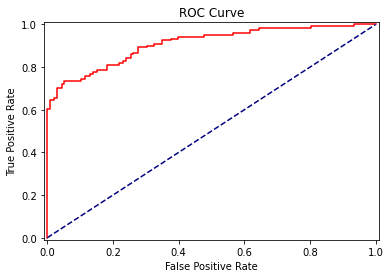

In [368]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_score)
plt.plot(fpr, tpr, color = 'red', label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--') # random prediction
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')